In [213]:
# setup plotting theme
from tufte_mpl import setup
setup()

In [215]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable
from enum import Enum, auto
%matplotlib inline

In [216]:
@dataclass
class Populations:
	# h: np.ndarray  # input potentials at time t. shape=(K,)
	W: np.ndarray  # interaction weights. shape=(K, K)
	tau: np.ndarray  # time constant of population activity
	R: float  # resistivity
	gain_fn: Callable[[np.ndarray], np.ndarray]  # F(h) : R^K -> R^K, gain function of each population
	I_ext: Callable[[float], np.ndarray]  # I_ext(t) : R+ -> R^K, external stimulus
	# ASSUMPTION : filter_fn is a dirac delta
	# filter_fn: Callable[[float], np.ndarray]  # alpha(s) : R -> R^K, filter function of each population

	def dh(self, t: float, h: np.ndarray):
		rhs = np.zeros_like(h)
		
		# Exponential decay
		rhs -= h
		
		# Network currents
		gain = self.gain_fn(h)
		filtered = gain  # filter_fn is a dirac delta, normally this is in integral form
		I_network = np.einsum('kn,n->k', self.W, filtered)
		rhs += self.R * I_network

		# External currents
		rhs += self.R * self.I_ext(t)

		# Apply tau
		rhs /= self.tau

		return rhs

	def simulate_h(self, h0: np.ndarray, t_span: tuple[float, float], dt_max: float = 0.1):
		res = scipy.integrate.solve_ivp(self.dh, t_span, h0, max_step=dt_max)
		return res

def sigmoid(x):
	return 0.5*(np.tanh(x) + 1)

def identity(x):
	return x

# Fixed vs. recurrent inhibition

## Excitatory population with self-coupling

### Varying constant $I_{ext}$

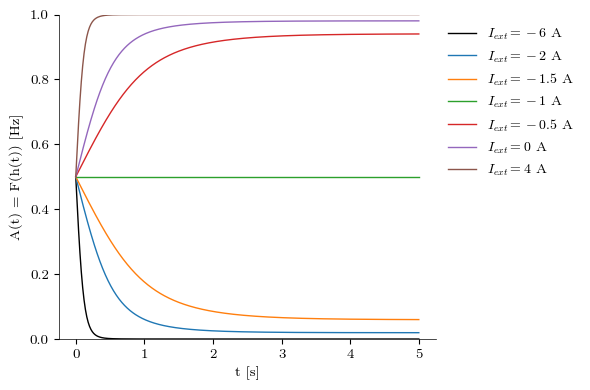

In [248]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=lambda t: np.array([I_ext]))
	res = pop.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('t [s]')
ax.set_ylabel('A(t) = F(h(t)) [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The activity levels out.

- $I_{ext} < -1 \; A$ : activity level decays to 0
- $I_{ext} = -1 \; A$ : threshold, activity level stays constant
- $I_{ext} > -1 \; A$ : activity level grows to 1

TODO : units of activity (Hz) ?

### Current spikes in steady state

In [218]:
class delta_bump:
	"""Numerical implementation of the Dirac delta using a sharp bump function"""

	# https://www.wolframalpha.com/input?i2d=true&i=Integrate%5Bexp%5C%2840%29-Divide%5B1%2C1-Power%5Bx%2C2%5D%5D%5C%2841%29%2C%7Bx%2C-1%2C1%7D%5D
	BUMP_INTEGRAL = 0.44399381616807943

	def __init__(self, t0: float, eps: float = 0.1):
		"""Numerical implementation of the Dirac delta using a sharp bump function
	
		During integration, use ``dt < eps/10`` for a good approximation of the integral

		Parameters
		----------
		t0 : float
			Peak of the delta approximation
		eps : float, optional
			Width of the peak, by default 0.1
		"""

		self.t0 = t0
		self.eps = eps

	def __call__(self, t: np.ndarray):
		x = 2/self.eps * (t - self.t0)
		return 2/self.eps * np.where(
			np.abs(x) < 1,
			np.exp(-1/(1-x**2)),
			np.zeros_like(t)
		) / delta_bump.BUMP_INTEGRAL

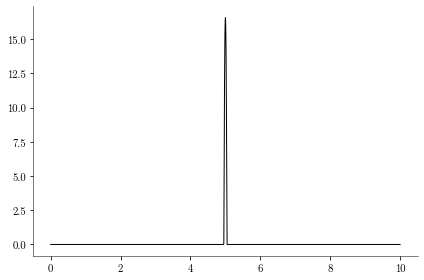

integral = 0.9999996783121823


In [219]:
# Test dirac delta approximation
t = np.linspace(0, 10, 5000)
plt.close('all')
plt.plot(t, delta_bump(5)(t))
plt.show()
print(f'integral = {np.trapz(delta_bump(5)(t), t)}')

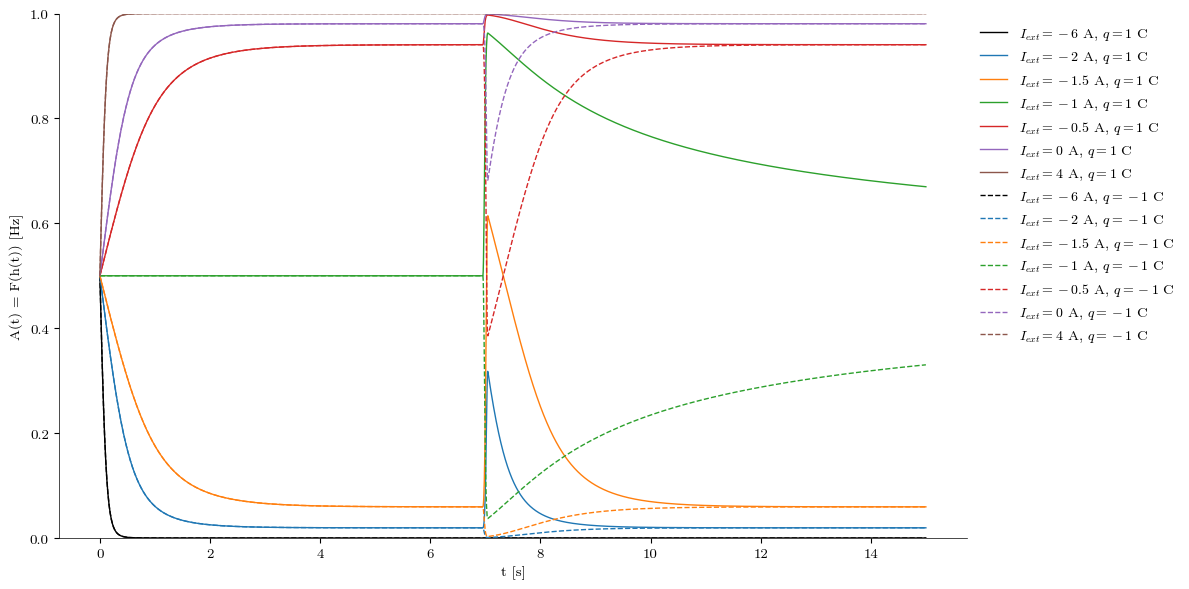

In [247]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
delta = delta_bump(7)

for iax, spike_charge in enumerate((1, -1)):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
		pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=lambda t: np.array([I_ext]) + spike_charge*delta(t))
		res = pop.simulate_h(np.array([0]), (0, 15), dt_max=delta.eps/20)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, $q = {spike_charge}$ C', linestyle='-' if iax == 0 else '--')

# ax.axvline(delta.t0, linestyle='--')
ax.set_xlabel('t [s]')
ax.set_ylabel('A(t) = F(h(t)) [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Current spike affects (higher amplitude, more time to recovery) unsaturated neurons ($|A| < 1$) more than saturated ones ($|A| \approx 1$).

It is not symmetric : if $A > 1/2$, then for $q < 0$ the perturbation is greather than for $q > 0$ (and vice-versa)

### Effect of coupling strength

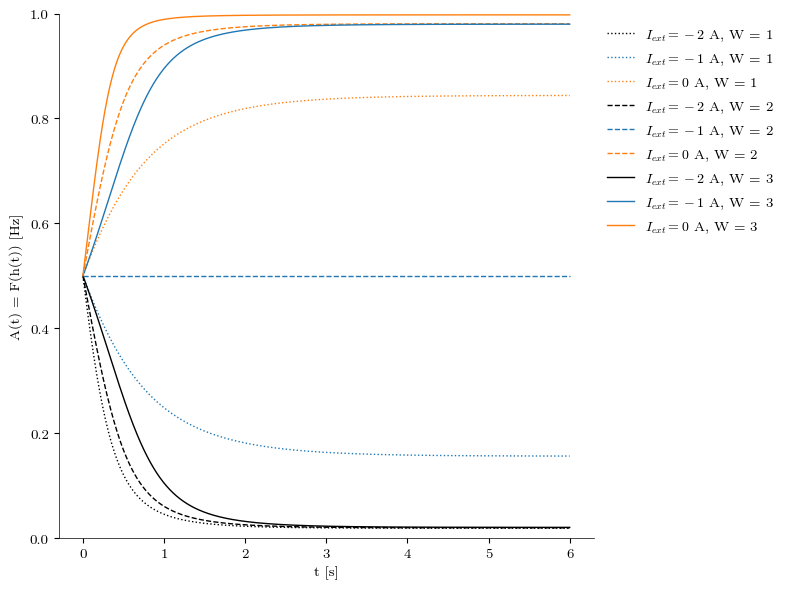

In [246]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for W in (1, 2, 3):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-2, -1, -0):
		pop = Populations(W=np.array([[W]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=lambda t: np.array([I_ext]))
		res = pop.simulate_h(np.array([0]), (0, 6), dt_max=0.01)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, W = {W}', linestyle={1: 'dotted', 2: 'dashed', 3: 'solid'}.get(W))

ax.set_xlabel('t [s]')
ax.set_ylabel('A(t) = F(h(t)) [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Changing coupling can change the equilibrium ($I_{ext} = 0 \; A$), but also the rate of convergence to the equilibrium ($I_{ext} = - 2 \; A$)
- Less coupling leads to less activity at all times

### Linear rate network

TODO : 
- does gain F apply to I_ext too ?
- how to apply last activation

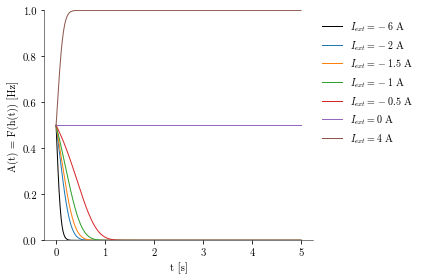

In [244]:
plt.close()
fig, ax = plt.subplots()

for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=identity, I_ext=lambda t: np.array([I_ext]))
	res = pop.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	ax.plot(res.t, sigmoid(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('t [s]')
ax.set_ylabel('A(t) = F(h(t)) [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Inhibitation-stabilized network

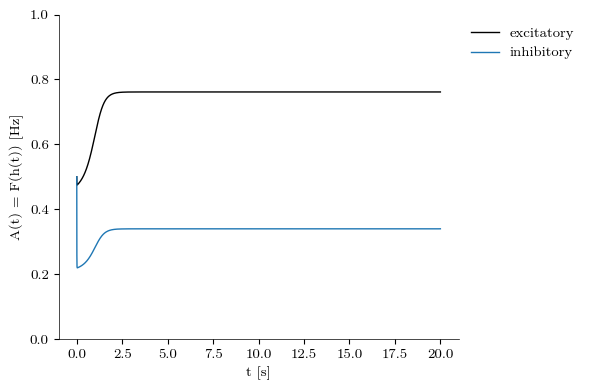

In [261]:
plt.close()
fig, ax = plt.subplots(dpi=100)

pop = Populations(W=np.array([[3.86, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=sigmoid, I_ext=lambda t: np.array([-1, -1]))
res = pop.simulate_h(np.array([0, 0]), (0, 20), dt_max=0.01)
ax.plot(res.t, pop.gain_fn(res.y[0]), label='excitatory')
ax.plot(res.t, pop.gain_fn(res.y[1]), label='inhibitory')

ax.set_xlabel('t [s]')
ax.set_ylabel('A(t) = F(h(t)) [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()